INICIO DEL MODELADO DEL CANAL RUIDOSO

In [1]:
#Importar librerias
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas
import komm

Obtención de datos de un archivo .txt

In [2]:
#Obtener datos del txt
getbinary = lambda x, n: format(x, 'b').zfill(n)    #transforma el nivel de cuantización a binario 
with open("data15.txt", "r") as f:
    data = [line[:-1] for line in f]

Convertidor de datos binarios a decimal

In [3]:
#Covertidor a decimal
def ConvDec(Datos):
    DatosDec=[]
    for Dnum in range(1,len(data)):
        DatoFiltrado=data[Dnum].replace(" ","")  #Añadido para leer el txt delimitado de manera distitna para evitar problemas
        DatosDec.append(int(DatoFiltrado,2))
    return DatosDec

Función que crea el canal ruidoso por medio de la biblioteca Komm

In [4]:
#Creación del canal con ruido AWGR
def CanalAWGN(SNR_dB,Entrada):
    Conv_snr=10**(SNR_dB/10) #Convierte el SNR de DB a Lineal
    awgn=komm.AWGNChannel(snr=Conv_snr,signal_power=1.5) #Utiliza el objeto de la biblioteca Komm para generar el ruido
    syr=awgn(Entrada)       #Se añade ruido a la señal original
    
    
    #Sección encargada de determinar la capacidad del canal en base a los parámetros obtenidos en la hoja de datos del nRF52832
    f_DS=2  ##Data rate en Mb/s
    M=2      ## Número de símbolos en  la modulación
    B_T=f_DS/(2*np.log2(M)) #Ancho de banda 
    C=2*B_T*awgn.capacity()   #Capacidad

    ###La funcion awgn.capacity() corresponde 1/2*log2(1+SNR)

    C_redondeada=round(C,3) #Redondea la capacidad del canal a 3 decimales
    print('Capacidad del canal es:',C_redondeada,'Mb/s') #Imprime la capacidad del canal
    
    
    
    #Evaluación de la saturación del canal
    if f_DS>=C:
        print("\n¡¡¡El canal está saturado!!!\n")
    else:
        print("\nLa tasa de transferencia no satura el canal\n")
    return syr

Función encargada de guardar el canal ruidoso.

In [5]:
def NS(Data,TamCode):
    np.savetxt("Ruidoso.txt", [int(TamCode)], fmt='%u', delimiter=' ') #Creación del archivo txt
    CodigoRuido=[int(TamCode)]   #Asignación del tamaño del codigo
    for decdato in Data:
        Nneg=max(0,decdato) #Filtación de numeros negativos 
        Nmax=min(Nneg,((2**int(TamCode))-1)) ##Filtración de numeros no respresentables en el tamaño del codigo
        BinRuido=getbinary(Nmax,int(TamCode))  #Conversión decimal-binaria 
        ProcCode=np.round(np.array(list(BinRuido),dtype=np.float32)).astype(int)  #Procesa el resultado binario 
        with open("Ruidoso.txt","a") as f:             #Guarda los datos procesados en el txt
            np.savetxt(f, [ProcCode], fmt='%1.0u', delimiter=' ')
        CodigoRuido.append(ProcCode) #Agrega el dato a la lista 
    return CodigoRuido

Declaración del conjunto de datos y el SNR utilizado

In [6]:
tsen = np.arange(0.01, 5.0, 0.01)  #periodo señal senoidal a probar
s1 = np.sin(2 * np.pi * tsen)      #funcion senoidal a probar

Datos_Codificados=ConvDec(data)   #Crea el conjunto de datos ya convertidos a decimal
SNR_dB=1                         #Declara el SNR a utilizar

Bloque principal del canal, aquí realiza el llamado a todas las funciones

Capacidad del canal es: 1.176 Mb/s

¡¡¡El canal está saturado!!!

Capacidad del canal es: 1.176 Mb/s

¡¡¡El canal está saturado!!!



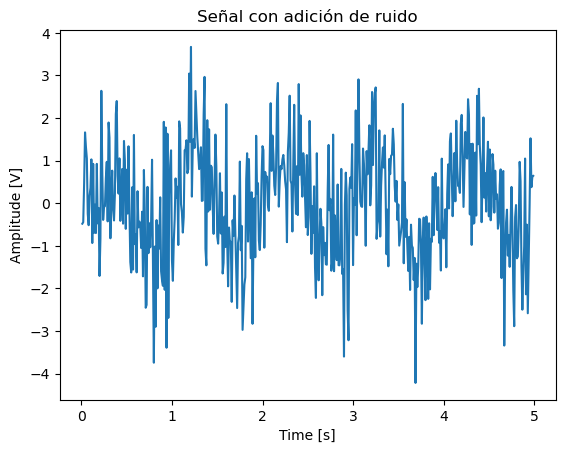

In [7]:
def EjecucionCanal(Datos,SNR_dB):                    #Función  principal del bloque del canal                                            
    CanalRuidoso=CanalAWGN(SNR_dB,Datos)            #Creación del canal ruidoso utilizando la función CANAL AWGN
    SenalRuidosaRedondeada=np.round(CanalRuidoso).astype(int)    #Redondea la senal ruidosa (array) a un int
    NoiseSave=NS(SenalRuidosaRedondeada,data[0])   #Guarda la señal ruidosa en bits
    
    return SenalRuidosaRedondeada

RuidoPrueba=CanalAWGN(SNR_dB,s1) 
RuidoSenal=EjecucionCanal(Datos_Codificados,SNR_dB)   #Llama la función principal del canal

#Visualización de la señal ruidosa.
#pltime=1200
sr=plt.figure()
sruidos=plt.plot(tsen,RuidoPrueba)
plt.title("Señal con adición de ruido")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.show()
sr.clear()

VIsualización de los datos

El dato enviado por el transmisor es  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]


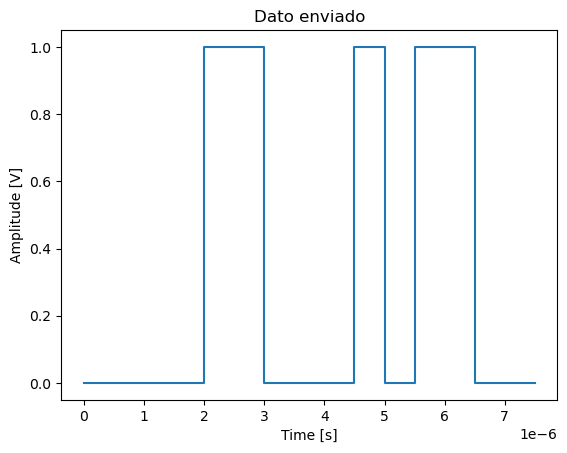

In [8]:
#Visualización del dato entrante
Indata=list(map(int,list(data[15].split())))
T_SoC=1/(2*10**6)
Indata.insert(0,Indata[0])   #Sin ruido

Time_data=np.linspace(0,(len(Indata)-1)*T_SoC,len(Indata))  ##Eje de tiempo basado en el tiempo del SoC de la hoja de datos

print("El dato enviado por el transmisor es ",list(Indata)) #impresión del dato recibido
recibido=plt.figure()
plotConRuido=plt.step(Time_data,Indata)
plt.title("Dato enviado")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.show()
recibido.clear()

Visualización del dato transmitido (Ruido)

El dato que llega al receptor cuando hay ruido es  [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1]


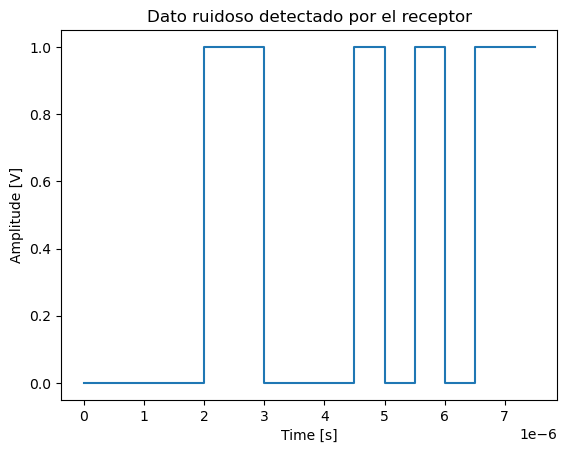

In [9]:
#Lectura del dato ruidoso a transmitir guardado en un txt
with open("Ruidoso.txt", "r") as f:
    DatosRuido = [line[:-1] for line in f]

#Impresión del dato recibido
DR1=list(map(int,list(DatosRuido[15].split())))
DR1.insert(0,DR1[0])
print("El dato que llega al receptor cuando hay ruido es ",DR1)    
#Gráfica del dato ruidoso
f1=plt.figure()
plotConRuido=plt.step(Time_data,DR1)
plt.title("Dato ruidoso detectado por el receptor")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [V]")
plt.show()
f1.clear()